In [1]:
Make sur you use a python version 3.9, 3.10, 3.11 or 3.12 to used the imbalanced-learn library.

SyntaxError: invalid syntax (3613851610.py, line 1)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter 

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc

# Tensorflow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# --- CHEMIN RELATIF PORTABLE ---
# '..' permet de sortir de votre dossier actuel pour remonter au dossier parent
PATH_CSV = '../DATA/CLEAN/Output_Road_Accident_Data.csv' 

def load_and_preprocess(filepath):
    if not os.path.exists(filepath):
        print(f" ERREUR : Fichier introuvable à : {filepath}")
        print(f"Vérifiez que vous avez bien un dossier 'DATA' au même niveau que votre dossier de travail.")
        return None
    
    df = pd.read_csv(filepath)
    # Sélection des 5 variables les plus discriminantes
    cols_to_keep = ['Urban_or_Rural_Area', 'Speed_limit', 'Light_Conditions', 
                    'Junction_Control', 'Junction_Detail', 'Accident_Severity']
    available_cols = [c for c in cols_to_keep if c in df.columns]
    df = df[available_cols].copy()
    # Suppression de la classe Serious pour maximiser le contraste
    df = df[df["Accident_Severity"] != "Serious"].copy()
    return df

print("✅ Configuration prête. Utilisation du chemin :", PATH_CSV)

✅ Configuration prête. Utilisation du chemin : ../DATA/CLEAN/Output_Road_Accident_Data.csv


In [ ]:
Phase 2 - Première Solution (SMOTE + Focal Loss)
Cette approche utilise un rééquilibrage artificiel des données combiné à une fonction de perte qui pénalise les erreurs sur la classe rare.

In [7]:
# 1. Préparation
df1 = load_and_preprocess(PATH_CSV)

if df1 is not None:
    X = pd.get_dummies(df1.drop(columns=["Accident_Severity"]), drop_first=True)
    y = df1["Accident_Severity"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train) # Fatal=0, Slight=1
    y_test_encoded = le.transform(y_test)

    # 2. SMOTE Manuel (Parité à ~179k échantillons)
    X_train_np = X_train.values.astype(np.float64)
    y_train_np = y_train.values
    counts_before = Counter(y_train_np)
    target_size = counts_before['Slight']

    X_smote, y_smote = list(X_train_np), list(y_train_np)
    fatal_indices = np.where(y_train_np == 'Fatal')[0]

    print(f"🔄 SMOTE : Génération de {target_size - counts_before['Fatal']} points pour la classe Fatal...")
    for _ in range(target_size - counts_before['Fatal']):
        idx1, idx2 = np.random.choice(fatal_indices, size=2, replace=False)
        diff = X_train_np[idx2] - X_train_np[idx1]
        X_smote.append(np.round(X_train_np[idx1] + np.random.random() * diff))
        y_smote.append('Fatal')

    X_train_res = np.array(X_smote)
    y_train_res = le.transform(y_smote)

    scaler = StandardScaler()
    X_train_final = scaler.fit_transform(X_train_res)
    X_test_final = scaler.transform(X_test.values)

    # 3. Modèle avec Focal Loss (Gamma=2.0, Alpha=0.6)
    def binary_focal_loss(gamma=2.0, alpha=0.6):
        def focal_loss(y_true, y_pred):
            y_true = tf.cast(y_true, tf.float32)
            y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
            p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))
            alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
            focal_term = tf.pow((1.0 - p_t), gamma)
            bce = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
            return tf.reduce_mean(alpha_factor * focal_term * bce)
        return focal_loss

    model1 = Sequential([
        Input(shape=(X_train_final.shape[1],)),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(), Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(), Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model1.compile(optimizer=Adam(1e-3), loss=binary_focal_loss(), metrics=[tf.keras.metrics.Recall()])
    model1.fit(X_train_final, y_train_res, epochs=10, batch_size=512, verbose=1)

    # 4. Évaluation (Seuil 0.4)
    y_probs1 = model1.predict(X_test_final)
    y_pred1 = (y_probs1 > 0.4).astype(int).flatten()
    print("\n--- RAPPORT SOLUTION 1 (SMOTE + FOCAL + SEUIL 0.4) ---")
    print(classification_report(y_test_encoded, y_pred1, target_names=le.classes_))

🔄 SMOTE : Génération de 163827 points pour la classe Fatal...
Epoch 1/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.2513 - recall_2: 0.7490
Epoch 2/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0719 - recall_2: 0.7973
Epoch 3/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0715 - recall_2: 0.7900
Epoch 4/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0716 - recall_2: 0.7723
Epoch 5/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0718 - recall_2: 0.7651
Epoch 6/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0718 - recall_2: 0.7576
Epoch 7/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0721 - recall_2: 0.7516
Epoch 8/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0718 - recall_2: 0.7597
Epoch 9/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0718 - recall_2: 0.7562
Epoch 10/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0718 - recall_2: 0.7530
2264/2264 ━━━━━━━━━━━━━━━━━━━━ 2s 764us/step

--- RAPPORT SOLUTION 1 (SMOTE +

c:\Users\Utilisateur\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Utilisateur\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Utilisateur\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavio

In [ ]:
Phase 2 - Logit Adjustment Loss (Optimisation F1-Score)
Cette solution utilise une approche statistique - Logit Adjustement Loss - pour décaler les scores en fonction de la rareté des classes, optimisée ici pour la précision globale de la classe Fatal.

Entraînement de la Solution 2 (LAL)...
2264/2264 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step

--- RAPPORT SOLUTION 2 (LAL F1 - Seuil optimal : 0.9641) ---
              precision    recall  f1-score   support

       Fatal       0.06      0.14      0.09      1117
      Slight       0.99      0.97      0.98     71330

    accuracy                           0.96     72447
   macro avg       0.52      0.55      0.53     72447
weighted avg       0.97      0.96      0.96     72447



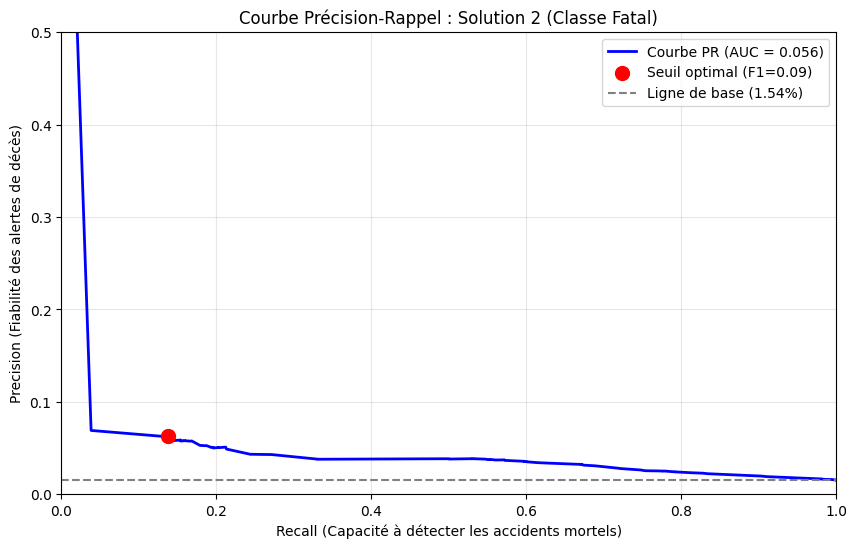

In [8]:
# 1. Préparation (Data originale)
df2 = load_and_preprocess(PATH_CSV)
if df2 is not None:
    X = pd.get_dummies(df2.drop(columns=["Accident_Severity"]), drop_first=True)
    y = df2["Accident_Severity"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    counts = Counter(y_train_encoded)
    priors = np.array([counts[0] / len(y_train_encoded), counts[1] / len(y_train_encoded)])

    scaler = StandardScaler()
    X_train_final = scaler.fit_transform(X_train)
    X_test_final = scaler.transform(X_test)

    # 2. Modèle LAL
    def logit_adjustment_loss(priors, tau=1.5):
        logit_offset = tau * (np.log(priors[1] + 1e-12) - np.log(priors[0] + 1e-12))
        def loss(y_true, y_pred_logits):
            y_true = tf.cast(y_true, tf.float32)
            return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred_logits + logit_offset))
        return loss

    model2 = Sequential([
        Input(shape=(X_train_final.shape[1],)),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(), Dropout(0.4),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(), Dropout(0.3),
        Dense(1, activation='linear')
    ])

    model2.compile(optimizer=Adam(5e-4), loss=logit_adjustment_loss(priors))
    
    print("Entraînement de la Solution 2 (LAL)...")
    model2.fit(X_train_final, y_train_encoded, epochs=50, batch_size=1024, verbose=0)

    # 3. Optimisation F1
    y_logits = model2.predict(X_test_final)
    y_probs2 = tf.nn.sigmoid(y_logits).numpy().flatten()
    
    # Calcul de la courbe pour la classe Fatal (pos_label=0)
    # On utilise 1 - y_probs2 car y_probs2 donne la probabilité de la classe 1 (Slight)
    prec, rec, thresh = precision_recall_curve(y_test_encoded, 1 - y_probs2, pos_label=0)
    
    f1 = 2 * (prec * rec) / (prec + rec + 1e-8)
    best_idx = np.argmax(f1)
    best_thresh_fatal = thresh[best_idx]
    
    # Application du seuil
    y_pred2 = ( (1 - y_probs2) >= best_thresh_fatal).astype(int)
    # Re-basculer les labels pour le rapport : Fatal est 0, Slight est 1
    y_pred_report = 1 - y_pred2

    print(f"\n--- RAPPORT SOLUTION 2 (LAL F1 - Seuil optimal : {best_thresh_fatal:.4f}) ---")
    print(classification_report(y_test_encoded, y_pred_report, target_names=le.classes_))

    # --- 4. TRACÉ DE LA COURBE PRÉCISION-RAPPEL ---
    plt.figure(figsize=(10, 6))
    plt.plot(rec, prec, color='blue', lw=2, label=f'Courbe PR (AUC = {auc(rec, prec):.3f})')
    
    # Marquage du point optimal (F1-score maximum)
    plt.scatter(rec[best_idx], prec[best_idx], color='red', s=100, 
                label=f'Seuil optimal (F1={f1[best_idx]:.2f})', zorder=5)
    
    # Ligne de base (proportion de cas mortels dans le test)
    baseline = counts[0] / len(y_train_encoded)
    plt.axhline(y=baseline, color='gray', linestyle='--', label=f'Ligne de base ({baseline:.2%})')

    plt.title('Courbe Précision-Rappel : Solution 2 (Classe Fatal)')
    plt.xlabel('Recall (Capacité à détecter les accidents mortels)')
    plt.ylabel('Precision (Fiabilité des alertes de décès)')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.xlim([0, 1.0])
    plt.ylim([0, 0.5]) # Zoom sur la zone utile car la précision est structurellement basse
    plt.show()

In [ ]:
Phase 2 - Logit Adjustment Loss (Optimisation Recall 66%)
Version finale orientée "Sécurité Préventive" : on accepte plus de faux positifs pour capturer 2/3 des accidents mortels.


RAPPORT SOLUTION 3 : OBJECTIF PRÉVENTION
Seuil de basculement calculé : 0.8914
              precision    recall  f1-score   support

       Fatal       0.03      0.67      0.06      1117
      Slight       0.99      0.69      0.81     71330

    accuracy                           0.69     72447
   macro avg       0.51      0.68      0.44     72447
weighted avg       0.98      0.69      0.80     72447



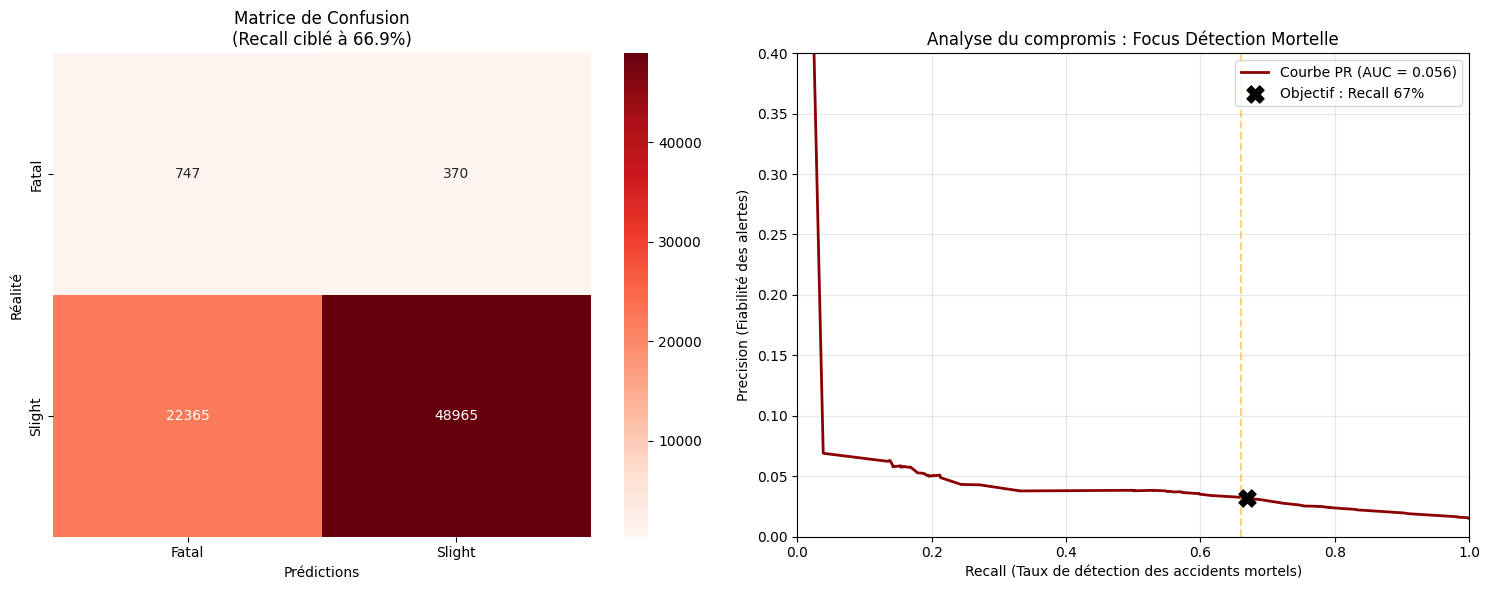

In [9]:
# --- SOLUTION 3 : OPTIMISATION POUR LA PRÉVENTION (RECALL 66%) ---

# 1. Calcul des métriques PR pour la classe Fatal (pos_label=0)
# On utilise les probabilités inversées car le modèle prédit la classe 1 (Slight) par défaut
y_probs_fatal = 1 - y_probs2 
precisions, recalls, thresholds = precision_recall_curve(y_test_encoded, y_probs_fatal, pos_label=0)

# 2. Recherche du seuil pour atteindre au moins 66% de Recall
# np.where renvoie les indices où la condition est vraie, on prend le dernier pour avoir le rappel le plus proche de 66%
idx_target = np.where(recalls >= 0.66)[0][-1]
threshold_66 = thresholds[idx_target]

# 3. Prédiction avec le nouveau seuil
y_pred_66 = (y_probs_fatal >= threshold_66).astype(int)
y_pred_final = 1 - y_pred_66 # On remet au format 0=Fatal, 1=Slight pour le rapport

print(f"\n" + "="*50)
print(f"RAPPORT SOLUTION 3 : OBJECTIF PRÉVENTION")
print(f"Seuil de basculement calculé : {threshold_66:.4f}")
print("="*50)
print(classification_report(y_test_encoded, y_pred_final, target_names=le.classes_))

# 4. Visualisations
plt.figure(figsize=(15, 6))

# --- Sous-graphe 1 : Matrice de Confusion ---
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test_encoded, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f"Matrice de Confusion\n(Recall ciblé à {recalls[idx_target]:.1%})")
plt.xlabel("Prédictions")
plt.ylabel("Réalité")

# --- Sous-graphe 2 : Courbe Precision-Recall ---
plt.subplot(1, 2, 2)
plt.plot(recalls, precisions, color='darkred', lw=2, label=f'Courbe PR (AUC = {auc(recalls, precisions):.3f})')

# Marquage du point spécifique à 66% de Recall
plt.scatter(recalls[idx_target], precisions[idx_target], color='black', s=150, marker='X',
            label=f'Objectif : Recall {recalls[idx_target]:.0%}', zorder=5)

# Ligne de rappel visuelle
plt.axvline(x=0.66, color='orange', linestyle='--', alpha=0.5)



plt.title('Analyse du compromis : Focus Détection Mortelle')
plt.xlabel('Recall (Taux de détection des accidents mortels)')
plt.ylabel('Precision (Fiabilité des alertes)')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.xlim([0, 1.0])
plt.ylim([0, 0.4]) # Focus sur la zone de performance réelle
plt.tight_layout()
plt.show()